In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm

# === CONFIG ===
clean_dir = "/content/drive/MyDrive/datasets/DIV2K_train_HR/DIV2K_train_HR"              # Folder with clean DIV2K images
noisy_output_dir = "/content/drive/MyDrive/datasets/Div2K_Noisy"    # Output folder for noisy images
os.makedirs(noisy_output_dir, exist_ok=True)


# === NOISE FUNCTIONS ===
def add_gaussian_noise(img, mean=0, sigma=25):
    gauss = np.random.normal(mean, sigma, img.shape).astype(np.int16)
    noisy = np.clip(img.astype(np.int16) + gauss, 0, 255).astype(np.uint8)
    return noisy

def add_salt_pepper_noise(img, prob=0.01):
    noisy = np.copy(img)
    h, w = img.shape[:2]
    num_salt = int(prob * h * w)
    num_pepper = int(prob * h * w)

    # Salt
    coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape[:2]]
    noisy[coords[0], coords[1]] = 255

    # Pepper
    coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape[:2]]
    noisy[coords[0], coords[1]] = 0

    return noisy

def add_speckle_noise(img):
    gauss = np.random.randn(*img.shape) * 0.2
    noisy = img + img * gauss
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

def add_cross_marks(img, num_lines=5):
    h, w, _ = img.shape
    for _ in range(num_lines):
        pt1 = (random.randint(0, w), random.randint(0, h))
        pt2 = (random.randint(0, w), random.randint(0, h))
        color = (0, 0, 0)  # black line
        thickness = random.randint(2, 5)
        img = cv2.line(img, pt1, pt2, color, thickness)
    return img


# === COMBINE NOISES AND DISTORTIONS ===
def apply_random_noise_and_marks(img):
    # Randomly apply 1-3 noise types
    methods = [add_gaussian_noise, add_salt_pepper_noise, add_speckle_noise]
    random.shuffle(methods)
    noisy_img = img.copy()

    for i in range(random.randint(1, 3)):
        noisy_img = methods[i](noisy_img)

    # Add scribbles/cross marks
    noisy_img = add_cross_marks(noisy_img, num_lines=random.randint(3, 6))

    return noisy_img


# === MAIN LOOP ===
image_files = [f for f in os.listdir(clean_dir) if f.lower().endswith(('.jpg', '.png'))]
print(f"Found {len(image_files)} image files in '{clean_dir}'")


for file in tqdm(image_files, desc="Generating noisy images"):
    img_path = os.path.join(clean_dir, file)
    img = cv2.imread(img_path)
    if img is None:
        continue

    noisy_img = apply_random_noise_and_marks(img)
    cv2.imwrite(os.path.join(noisy_output_dir, file), noisy_img)

print("Finished generating noisy images.")


Found 800 image files in '/content/drive/MyDrive/datasets/DIV2K_train_HR/DIV2K_train_HR'


Generating noisy images:  12%|█▏        | 94/800 [03:44<28:04,  2.39s/it]


KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torchvision.utils as vutils


# DnCNN Model Definition
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_of_layers=17):
        super(DnCNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(channels, 64, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))

        for _ in range(num_of_layers - 2):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))

        layers.append(nn.Conv2d(64, channels, kernel_size=3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out  # Residual learning



In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torchvision.utils as vutils

# DnCNN Model Definition
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_of_layers=17):
        super(DnCNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(channels, 64, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))

        for _ in range(num_of_layers - 2):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))

        layers.append(nn.Conv2d(64, channels, kernel_size=3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out  # Residual learning

# Custom Dataset
class DIV2KDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_files = sorted(os.listdir(noisy_dir))
        self.clean_files = sorted(os.listdir(clean_dir))
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        noisy_path = os.path.join(self.noisy_dir, self.noisy_files[idx])
        clean_path = os.path.join(self.clean_dir, self.clean_files[idx])

        noisy = Image.open(noisy_path).convert("RGB")
        clean = Image.open(clean_path).convert("RGB")

        return self.transform(noisy), self.transform(clean)

# Training Parameters
BATCH_SIZE = 8
EPOCHS = 20
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Paths
clean_dir = "/content/drive/MyDrive/Final Project/Div2K/DIV2K_train_HR"
noisy_dir = "/content/drive/MyDrive/Final Project/Div2K/Div2K_Noisy"
'''
print(f"Found {len(os.listdir(noisy_dir))} noisy files")
print(f"Found {len(os.listdir(clean_dir))} clean files")



# Get filenames in each directory (just base names)
noisy_files = set(os.listdir(noisy_dir))
clean_files = set(os.listdir(clean_dir))

# Compare
missing_in_clean = noisy_files - clean_files
missing_in_noisy = clean_files - noisy_files

if missing_in_clean:
    print("❌ Files in NOISY but missing in CLEAN:")
    for f in sorted(missing_in_clean):
        print(f" - {f}")

if missing_in_noisy:
    print("❌ Files in CLEAN but missing in NOISY:")
    for f in sorted(missing_in_noisy):
        print(f" - {f}")

if not missing_in_clean and not missing_in_noisy:
    print("✅ All files are matched!")

'''
# Dataset & DataLoader
dataset = DIV2KDataset(noisy_dir, clean_dir)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Model, Loss, Optimizer
model = DnCNN().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training Loop
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    for noisy, clean in tqdm(dataloader, desc=f"Epoch {epoch}/{EPOCHS}"):
        noisy = noisy.to(DEVICE)
        clean = clean.to(DEVICE)

        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch}/{EPOCHS}] - Loss: {avg_loss:.4f}")

    # Save sample output every few epochs
    if epoch % 5 == 0:
        vutils.save_image(output[:4], f"output_epoch_{epoch}.png", nrow=2, normalize=True)

# Save final model
torch.save(model.state_dict(), "/content/drive/MyDrive/Final Project/Div2K/dncnn_div2k.pth")
print("Training complete. Model saved as dncnn_div2k.pth")


Epoch 1/20: 100%|██████████| 100/100 [07:48<00:00,  4.68s/it]


Epoch [1/20] - Loss: 0.0067


Epoch 2/20: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


Epoch [2/20] - Loss: 0.0014


Epoch 3/20: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch [3/20] - Loss: 0.0014


Epoch 4/20: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


Epoch [4/20] - Loss: 0.0013


Epoch 5/20: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


Epoch [5/20] - Loss: 0.0011


Epoch 6/20: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch [6/20] - Loss: 0.0009


Epoch 7/20: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch [7/20] - Loss: 0.0009


Epoch 8/20: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch [8/20] - Loss: 0.0008


Epoch 9/20: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch [9/20] - Loss: 0.0007


Epoch 10/20: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


Epoch [10/20] - Loss: 0.0007


Epoch 11/20: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch [11/20] - Loss: 0.0007


Epoch 12/20: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


Epoch [12/20] - Loss: 0.0007


Epoch 13/20: 100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


Epoch [13/20] - Loss: 0.0007


Epoch 14/20: 100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


Epoch [14/20] - Loss: 0.0007


Epoch 15/20: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch [15/20] - Loss: 0.0007


Epoch 16/20: 100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


Epoch [16/20] - Loss: 0.0006


Epoch 17/20: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch [17/20] - Loss: 0.0006


Epoch 18/20: 100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


Epoch [18/20] - Loss: 0.0006


Epoch 19/20: 100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


Epoch [19/20] - Loss: 0.0007


Epoch 20/20: 100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


Epoch [20/20] - Loss: 0.0006
Training complete. Model saved as dncnn_div2k.pth


In [ ]:
import os
print(os.path.exists("/content/drive/MyDrive/Final Project/Div2K/dncnn_div2k.pth"))  # Should print True


True


In [ ]:
# Create model instance
model = DnCNN()
model.load_state_dict(torch.load("/content/drive/MyDrive/Final Project/Div2K/dncnn_div2k.pth", map_location="cpu"))
model.eval()


DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2

In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00


In [3]:
import gradio as gr
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import cv2
import random
from PIL import Image, ImageDraw
# === DnCNN model definition ===
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_of_layers=17):
        super(DnCNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(channels, 64, 3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers - 2):
            layers.append(nn.Conv2d(64, 64, 3, padding=1))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(64, channels, 3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out

# === Load model ===
model = DnCNN()
model.load_state_dict(torch.load("/content/drive/MyDrive/datasets/dncnn_div2k.pth", map_location="cpu"))
model.eval()

# === Noise functions from your script ===
def add_gaussian_noise(img, mean=0, sigma=25):
    gauss = np.random.normal(mean, sigma, img.shape).astype(np.int16)
    noisy = np.clip(img.astype(np.int16) + gauss, 0, 255).astype(np.uint8)
    return noisy

def add_salt_pepper_noise(img, prob=0.01):
    noisy = np.copy(img)
    h, w = img.shape[:2]
    num_salt = int(prob * h * w)
    num_pepper = int(prob * h * w)
    coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape[:2]]
    noisy[coords[0], coords[1]] = 255
    coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape[:2]]
    noisy[coords[0], coords[1]] = 0
    return noisy

def add_speckle_noise(img):
    gauss = np.random.randn(*img.shape) * 0.2
    noisy = img + img * gauss
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

def add_cross_marks(img, num_lines=5):
    h, w, _ = img.shape
    for _ in range(num_lines):
        pt1 = (random.randint(0, w), random.randint(0, h))
        pt2 = (random.randint(0, w), random.randint(0, h))
        color = (0, 0, 0)
        thickness = random.randint(2, 5)
        img = cv2.line(img, pt1, pt2, color, thickness)
    return img

def apply_random_noise_and_marks(img):
    methods = [add_gaussian_noise, add_salt_pepper_noise, add_speckle_noise]
    random.shuffle(methods)
    noisy_img = img.copy()
    for i in range(random.randint(1, 3)):
        noisy_img = methods[i](noisy_img)
    noisy_img = add_cross_marks(noisy_img, num_lines=random.randint(3, 6))
    return noisy_img

# === Gradio inference functions ===
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
resize = transforms.Resize((256, 256))

def add_noise(image_pil):
    image_np = np.array(image_pil.convert("RGB"))
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    noisy_np = apply_random_noise_and_marks(image_np)
    noisy_rgb = cv2.cvtColor(noisy_np, cv2.COLOR_BGR2RGB)
    return Image.fromarray(noisy_rgb)

def denoise_image(image_pil):
    image_resized = resize(image_pil)
    input_tensor = to_tensor(image_resized).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
    output_img = output.squeeze(0).clamp(0, 1)
    return to_pil(output_img)

# === Gradio UI ===
with gr.Blocks() as demo:
    gr.Markdown("## 🎯 Upload → Add Noise → Denoise")

    with gr.Row():
        original = gr.Image(label="Original Image", type="pil")
        noisy = gr.Image(label="Noisy Image", type="pil")
        denoised = gr.Image(label="Denoised Output", type="pil")

    with gr.Row():
        noise_btn = gr.Button("🎨 Add Noise")
        denoise_btn = gr.Button("🧼 Denoise")

    noise_btn.click(add_noise, inputs=original, outputs=noisy)
    denoise_btn.click(denoise_image, inputs=noisy, outputs=denoised)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d7952865fd89bdf43e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Adding random noise programatically and then inpainting

In [9]:
import gradio as gr
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import cv2
import random
from PIL import Image

# === DnCNN Model Definition ===
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_of_layers=17):
        super(DnCNN, self).__init__()
        layers = [nn.Conv2d(channels, 64, 3, padding=1), nn.ReLU(inplace=True)]
        for _ in range(num_of_layers - 2):
            layers += [nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True)]
        layers.append(nn.Conv2d(64, channels, 3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out

# === Load pretrained model ===
model = DnCNN()
model.load_state_dict(torch.load("/content/drive/MyDrive/datasets/dncnn_div2k.pth", map_location="cpu"))
model.eval()

# === Noise Functions ===
def add_gaussian_noise(img, mean=0, sigma=25):
    gauss = np.random.normal(mean, sigma, img.shape).astype(np.int16)
    noisy = np.clip(img.astype(np.int16) + gauss, 0, 255).astype(np.uint8)
    return noisy

def add_salt_pepper_noise(img, prob=0.01):
    noisy = img.copy()
    h, w = img.shape[:2]
    num_salt = int(prob * h * w)
    num_pepper = int(prob * h * w)
    coords_s = [np.random.randint(0, i - 1, num_salt) for i in (h, w)]
    coords_p = [np.random.randint(0, i - 1, num_pepper) for i in (h, w)]
    noisy[coords_s[0], coords_s[1]] = 255
    noisy[coords_p[0], coords_p[1]] = 0
    return noisy

def add_speckle_noise(img):
    gauss = np.random.randn(*img.shape) * 0.2
    noisy = img + img * gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_cross_marks(img, num_lines=5):
    h, w = img.shape[:2]
    for _ in range(num_lines):
        pt1 = (random.randint(0, w), random.randint(0, h))
        pt2 = (random.randint(0, w), random.randint(0, h))
        img = cv2.line(img, pt1, pt2, (0, 0, 0), random.randint(2, 5))
    return img

def apply_random_noise_and_marks(img):
    methods = [add_gaussian_noise, add_salt_pepper_noise, add_speckle_noise]
    random.shuffle(methods)
    for i in range(random.randint(1, 3)):
        img = methods[i](img)
    img = add_cross_marks(img, num_lines=random.randint(3, 6))
    return img

# === Denoising with DnCNN ===
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
resize = transforms.Resize((256, 256))

def denoise_with_dncnn(image_bgr):
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)
    image_resized = resize(image_pil)
    input_tensor = to_tensor(image_resized).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)

    output_img = output.squeeze(0).clamp(0, 1)
    output_pil = to_pil(output_img)
    output_np = np.array(output_pil)
    output_bgr = cv2.cvtColor(output_np, cv2.COLOR_RGB2BGR)
    return output_bgr

# === Full Pipeline ===
def process_pipeline(image_pil):
    try:
        # Step 1: Convert PIL to OpenCV BGR
        original_rgb = np.array(image_pil.convert("RGB"))
        original_bgr = cv2.cvtColor(original_rgb, cv2.COLOR_RGB2BGR)

        print("Original BGR shape:", original_bgr.shape)

        # Step 2: Add noise + cross marks
        noisy_bgr = apply_random_noise_and_marks(original_bgr.copy())
        print("Noisy image created.")

        # Step 3: Create mask for black lines (cross marks)
        gray = cv2.cvtColor(noisy_bgr, cv2.COLOR_BGR2GRAY)
        mask = cv2.inRange(gray, 0, 10)
        print("Mask shape:", mask.shape)

        # Step 4: Inpaint the noisy image (remove cross marks)
        inpainted_bgr = cv2.inpaint(noisy_bgr, mask, 3, cv2.INPAINT_TELEA)
        print("Inpainting completed.")

        # Step 5: Apply Gaussian blur to the inpainted image to reduce noise
        inpainted_bgr_blurred = cv2.GaussianBlur(inpainted_bgr, (5, 5), 0)
        print("Applied Gaussian Blur to reduce noise.")

        # Convert inpainted and blurred image to RGB PIL
        inpainted_rgb = cv2.cvtColor(inpainted_bgr_blurred, cv2.COLOR_BGR2RGB)
        inpainted_pil = Image.fromarray(inpainted_rgb)

        # Step 6: Denoise the blurred inpainted image using DnCNN
        inpainted_resized = resize(inpainted_pil)
        input_tensor = to_tensor(inpainted_resized).unsqueeze(0)

        with torch.no_grad():
            output = model(input_tensor)
        output_tensor = output.squeeze(0).clamp(0, 1)
        output_pil = to_pil(output_tensor)
        print("DnCNN output generated.")

        # Convert everything to RGB for display
        noisy_rgb = cv2.cvtColor(noisy_bgr, cv2.COLOR_BGR2RGB)
        denoised_rgb = cv2.cvtColor(np.array(output_pil), cv2.COLOR_RGB2BGR)

        # Convert final outputs
        return (
            Image.fromarray(original_rgb),
            Image.fromarray(noisy_rgb),
            Image.fromarray(inpainted_rgb),
            Image.fromarray(denoised_rgb)
        )

    except Exception as e:
        print("Pipeline Error:", e)
        return None, None, None, None



# === Gradio UI ===
with gr.Blocks() as demo:
    gr.Markdown("## 🧽 DnCNN Denoising + 🩹 Inpainting")

    input_img = gr.Image(label="Upload Image", type="pil")
    run_btn = gr.Button("▶️ Add Noise and Denoise")

    with gr.Row():
        original = gr.Image(label="Original", interactive=False)
        noisy = gr.Image(label="Noisy + Marks", interactive=False)
        denoised = gr.Image(label="After Denoising", interactive=False)
       # inpainted = gr.Image(label="After Inpainting", interactive=False)

    run_btn.click(process_pipeline, inputs=input_img, outputs=[original, noisy, denoised, inpainted])

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f3849fd606a402cccf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Saving Syena citi.webp to Syena citi.webp


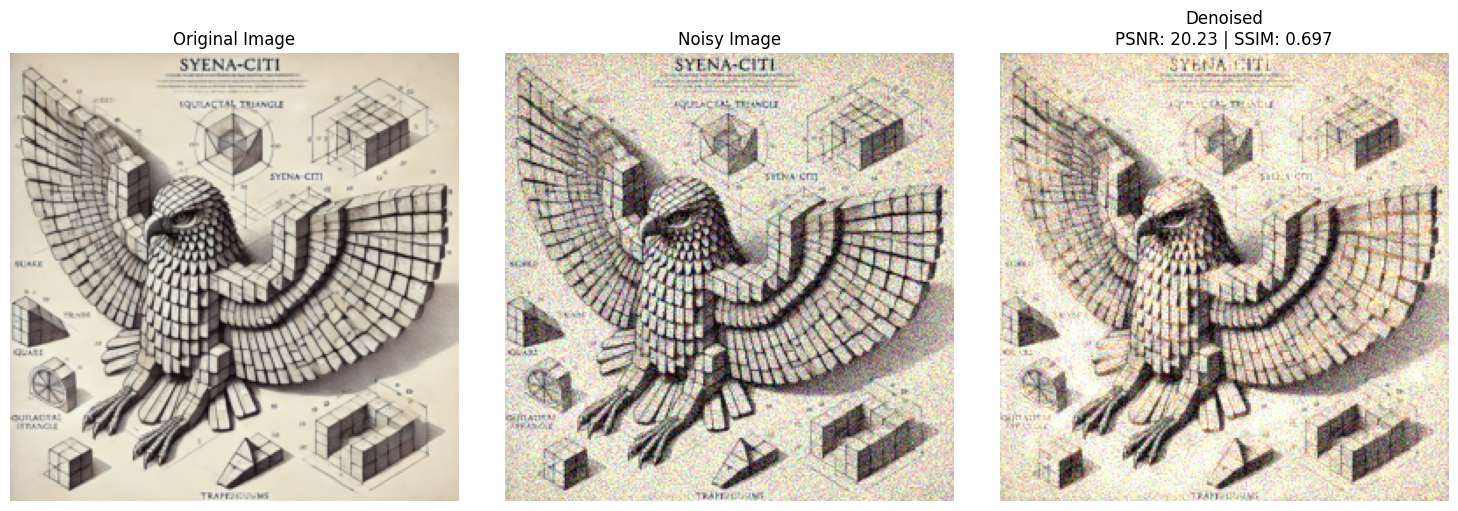

In [8]:
# Install dependencies
!pip install scikit-image

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
from PIL import Image
import cv2

# === DnCNN model definition ===
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_of_layers=17):
        super(DnCNN, self).__init__()
        layers = [nn.Conv2d(channels, 64, 3, padding=1), nn.ReLU(inplace=True)]
        for _ in range(num_of_layers - 2):
            layers += [nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True)]
        layers.append(nn.Conv2d(64, channels, 3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out

# === Load trained model ===
model = DnCNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/dncnn_div2k.pth', map_location='cpu'))  # <-- Upload your model
model.eval()

# === Image utilities ===
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
resize = transforms.Resize((256, 256))

# Add Gaussian noise
def add_gaussian_noise(img, mean=0, sigma=25):
    gauss = np.random.normal(mean, sigma, img.shape).astype(np.int16)
    noisy = np.clip(img.astype(np.int16) + gauss, 0, 255).astype(np.uint8)
    return noisy

# === Upload and process image ===
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    original_pil = Image.open(filename).convert("RGB")
    original_pil = resize(original_pil)
    original_np = np.array(original_pil)

    # Add noise
    noisy_np = add_gaussian_noise(original_np)
    noisy_pil = Image.fromarray(noisy_np)

    # Denoise
    input_tensor = to_tensor(noisy_pil).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
    output_img = output.squeeze(0).clamp(0, 1)
    denoised_pil = to_pil(output_img)

    # Metrics
    original_gray = cv2.cvtColor(np.array(original_pil), cv2.COLOR_RGB2GRAY)
    denoised_gray = cv2.cvtColor(np.array(denoised_pil), cv2.COLOR_RGB2GRAY)
    psnr_val = psnr_metric(original_gray, denoised_gray)
    ssim_val = ssim_metric(original_gray, denoised_gray)

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_pil)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(noisy_pil)
    axes[1].set_title("Noisy Image")
    axes[1].axis("off")

    axes[2].imshow(denoised_pil)
    axes[2].set_title(f"Denoised\nPSNR: {psnr_val:.2f} | SSIM: {ssim_val:.3f}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
